In [3]:
import sys
import importlib.metadata
def test_package(package_name):
    """Pruebe si el paquete existe y devuelve la versión o -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('instalando pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

instalando pyTEMlib

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
done


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
    
from matplotlib.patches import Circle

import pyTEMlib
from pyTEMlib import image_tools as it
from pyTEMlib import animation

import scipy.ndimage as ndimage

In [5]:
def make_chi( phi, theta, aberrations):
    maximum_aberration_order = 5
    chi = np.zeros(theta.shape)
    for n in range(maximum_aberration_order+1):  ## Primera suma hasta quinto orden
        term_first_sum = np.power(theta,n+1)/(n+1) # Término en la primera suma
                
        second_sum = np.zeros(theta.shape)  ## Segunda suma inicializada con ceros
        for m in range((n+1)%2,n+2, 2):
            if  m >0: 
                if f'C{n}{m}a' not in aberrations: # Establecer el coeficiente de aberraciones inexistentes en cero
                    aberrations[f'C{n}{m}a'] = 0.
                if f'C{n}{m}b' not in aberrations:
                    aberrations[f'C{n}{m}b'] = 0.
                    
                # Término en segunda suma
                second_sum = second_sum + aberrations[f'C{n}{m}a'] *np.cos(m* phi) + aberrations[f'C{n}{m}b'] *np.sin(m* phi)
            else:
                if f'C{n}{m}' not in aberrations: # Establecer el coeficiente de aberraciones inexistentes en cero
                    aberrations[f'C{n}{m}'] =  0.
                    
                # Término en segunda suma
                second_sum = second_sum + aberrations[f'C{n}{m}']
        chi = chi + term_first_sum * second_sum *2*np.pi/ aberrations['wavelength']
        
    return chi

Text(0.5, 1.0, 'Ronchigrama')

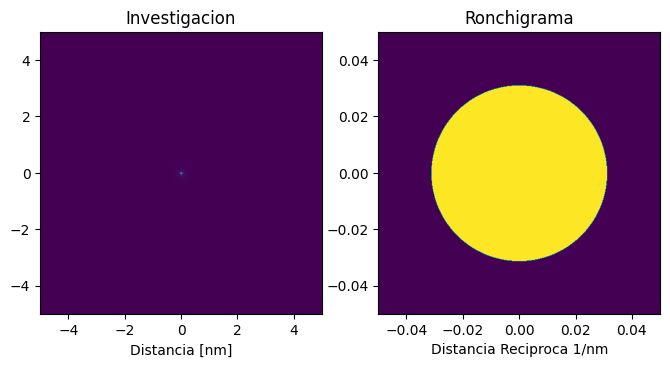

In [6]:
# ---Aporte  ----
convergence_angle = 40 # en mrad [mili-radianes]
FOV = 10 # en 1/nm
acceleration_voltage_V = 200000
# ---------------

ApAngle=convergence_angle/1000.0 # en rad 

wl = it.get_wavelength(acceleration_voltage_V)
sizeX = sizeY = 512

## Plano recíproco en 1/nm
dk = 1/FOV
kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
Txv, Tyv = np.meshgrid(kx, ky)

# Definir plano recíproco en ángulos
phi =  np.arctan2(Txv, Tyv)
theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

## Funcion Apertura 
mask = theta >= ApAngle

aperture =np.ones((sizeX,sizeY),dtype=float)
aperture[mask] = 0.
    
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((np.abs(np.fft.fftshift(np.fft.ifft2(aperture)))), extent = [-int(FOV/2),int(FOV/2),-int(FOV/2),int(FOV/2)])
ax[0].set_xlabel('Distancia [nm]')
ax[0].set_title('Investigacion')
ax[1].imshow(aperture, extent = [-(1/FOV/2),(1/FOV/2),-(1/FOV/2),(1/FOV/2)])
ax[1].set_xlabel('Distancia Reciproca 1/nm')
ax[1].set_title('Ronchigrama')

In [7]:
def get_chi( ab, sizeX, sizeY, verbose= False):      
    """
    ####
    # Internally reciprocal lattice vectors in 1/nm or rad.
    # All calculations of chi in angles.
    # All aberration coefficients in nm
    """
    ApAngle=ab['convergence_angle']/1000.0 # in rad

    wl = it.get_wavelength(ab['acceleration_voltage'])
    if verbose:
        print(f"Acceleration voltage {ab['acceleration_voltage']/1000:}kV => wavelength {wl*1000.:.2f}pm")
              
    ab['wavelength'] = wl


    ## Reciprocal plane in 1/nm
    dk = 1/ab['FOV']
    kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
    ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
    Txv, Tyv = np.meshgrid(kx, ky)

    # define reciprocal plane in angles
    phi =  np.arctan2(Txv, Tyv)
    theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

    ## calculate chi 
    chi = (make_chi(phi,theta,ab))
    
    ## Aperture funcion 
    mask = theta >= ApAngle

    aperture =np.ones((sizeX,sizeY),dtype=float)
    aperture[mask] = 0.

    
    return chi, aperture

In [8]:
#camera length as field of view in mrad 
sizeX = sizeY =512

ab ={}
ab['FOV'] = 20 # in nm
ab['convergence_angle'] = 120 ## let have a little bit of a view
ab['acceleration_voltage'] = 200000
ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])*10

ab['C10'] = -1590
ab['C30'] = 2.2e6
ab['Cc'] = ab['C30']
 
chi, A_k = get_chi( ab, sizeX, sizeY)

T_k =   A_k * np.exp(-1j*chi)

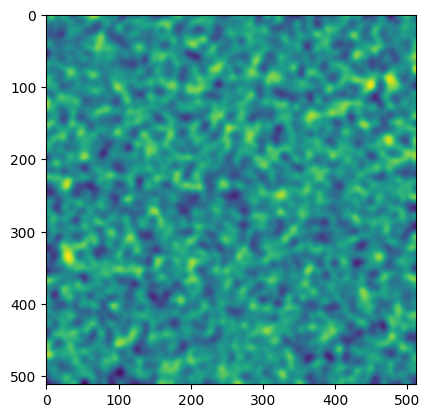

In [9]:
V_noise  =np.random.rand(sizeX,sizeY)
smoothing = 5
phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)

sigma = 6 ## 6 for carbon and thin

q_r = np.exp(-1j*sigma * phi_r)
#q_r = 1-phi_r * sigma

T_k =  (A_k)*(np.exp(-1j*chi))
t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

Psi_k =  np.fft.fftshift(np.fft.fft2(q_r*t_r))
plt.figure()
plt.imshow(phi_r)

In [10]:
def print_abberrations(ab):
    from IPython.display import HTML, display
    output = '<html><body>'
    output+= f"Abberrations [nm] for acceleration voltage: {ab['acceleration_voltage']/1e3:.0f} kV"
    output+= '<table>'
    output+= f"<tr><td> C10 </td><td> {ab['C10']:.1f} </tr>"
    output+= f"<tr><td> C12a </td><td> {ab['C12a']:20.1f} <td> C12b </td><td> {ab['C12b']:20.1f} </tr>"
    output+= f"<tr><td> C21a </td><td> {ab['C21a']:.1f} <td> C21b </td><td> {ab['C21b']:.1f} "
    output+= f"    <td> C23a </td><td> {ab['C23a']:.1f} <td> C23b </td><td> {ab['C23b']:.1f} </tr>"
    output+= f"<tr><td> C30 </td><td> {ab['C30']:.1f} </tr>"
    output+= f"<tr><td> C32a </td><td> {ab['C32a']:20.1f} <td> C32b </td><td> {ab['C32b']:20.1f} "
    output+= f"<td> C34a </td><td> {ab['C34a']:20.1f} <td> C34b </td><td> {ab['C34b']:20.1f} </tr>"
    output+= f"<tr><td> C41a </td><td> {ab['C41a']:.3g} <td> C41b </td><td> {ab['C41b']:.3g} "
    output+= f"    <td> C43a </td><td> {ab['C43a']:.3g} <td> C43b </td><td> {ab['C41b']:.3g} "
    output+= f"    <td> C45a </td><td> {ab['C45a']:.3g} <td> C45b </td><td> {ab['C45b']:.3g} </tr>"
    output+= f"<tr><td> C50 </td><td> {ab['C50']:.3g} </tr>"
    output+= f"<tr><td> C52a </td><td> {ab['C52a']:20.1f} <td> C52b </td><td> {ab['C52b']:20.1f} "
    output+= f"<td> C54a </td><td> {ab['C54a']:20.1f} <td> C54b </td><td> {ab['C54b']:20.1f} "
    output+= f"<td> C56a </td><td> {ab['C56a']:20.1f} <td> C56b </td><td> {ab['C56b']:20.1f} </tr>"
    output+= f"<tr><td> Cc </td><td> {ab['Cc']:.3g} </tr>"

    output+='</table></body></html>'

    display(HTML(output))

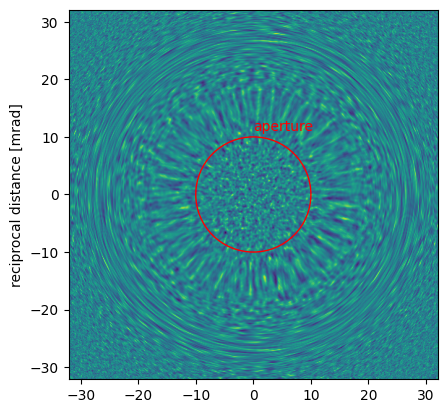

In [11]:
from matplotlib.patches import Circle
# in nm
ronchigram = I_k  = np.absolute(Psi_k*np.conjugate(Psi_k))

## scale of ronchigram
FOV_reciprocal = 1/ab['FOV']*sizeX/2 
extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
ylabel = 'reciprocal distance [1/nm]'

FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
ylabel = 'reciprocal distance [mrad]'


plt.figure()
plt.imshow(ronchigram, extent = extent)
plt.ylabel(ylabel)
#plt.imshow(phi_r)

print_abberrations(ab)
condensor_aperture = Circle((0, 0), radius = 10, fill = False, color = 'red')
plt.text(0,11,s='aperture', color = 'red')
plt.gca().add_patch(condensor_aperture);

In [12]:
def get_ronchigram(size, ab, scale = 'mrad' ):
    sizeX = sizeY = size
    chi, A_k  = get_chi( ab, sizeX, sizeY)
    
    V_noise  = np.random.rand(sizeX,sizeY)
    smoothing = 5
    phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)

    sigma = 6 ## 6 for carbon and thin

    q_r = np.exp(-1j*sigma * phi_r)
    #q_r = 1-phi_r * sigma

    T_k =  (A_k)*(np.exp(-1j*chi))
    t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

    Psi_k =  np.fft.fftshift(np.fft.fft2(q_r*t_r))


    ronchigram = I_k  = np.absolute(Psi_k*np.conjugate(Psi_k))

    FOV_reciprocal = 1/ab['FOV']*sizeX/2 
    if scale == '1/nm':
        extent = [-FOV_reciprocal,FOV_reciprocal,-FOV_reciprocal,FOV_reciprocal]
        ylabel = 'reciprocal distance [1/nm]'
    else :
        FOV_mrad = FOV_reciprocal * ab['wavelength'] *1000
        extent = [-FOV_mrad,FOV_mrad,-FOV_mrad,FOV_mrad]
        ylabel = 'reciprocal distance [mrad]'
    ab['chi'] = chi
    ab['ronchi_extent'] = extent
    ab['ronchi_label'] = ylabel
    return ronchigram

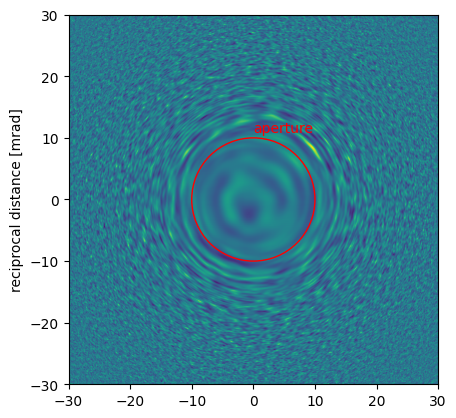

In [13]:
# --- APORTE --------------
aperture_radius = 10
ab ={}
ab['C10'] =  -190#0.16957899999999998
ab['C12a'] =  2.42161
ab['C12b'] =  0.9639660000000001
ab['C21a'] =  -114.478
ab['C21b'] =  -30.4613
ab['C23a'] =  2.4295
ab['C23b'] =  -17.3943
ab['C30'] =  2.2e6
ab['acceleration_voltage'] = 200000
# --------------------------

ab['wavelength'] = it.get_wavelength(ab['acceleration_voltage'])

ronchi_FOV = 60 #mrad
ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = 570 ## let have a little bit of a view
ab['Cc']= 1e6
ronchigram = get_ronchigram(1024, ab, scale = 'mrad'  )

plt.figure()
plt.imshow((ronchigram), extent = ab['ronchi_extent'])
plt.ylabel(ab['ronchi_label'])
print_abberrations(ab)
    

condensor_aperture = Circle((0, 0), radius = aperture_radius, fill = False, color = 'red')
plt.text(0,11,s='aperture', color = 'red')
plt.gca().add_patch(condensor_aperture)


Text(0, 0.5, 'reciprocal distance [mrad]')

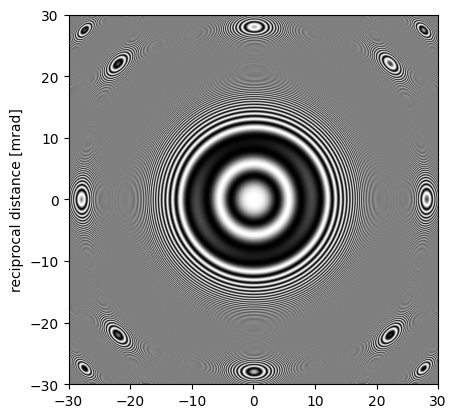

In [14]:
ronchigram = get_ronchigram(1024, ab, scale = 'mrad'  )
phase_plate =  np.cos(-ab['chi'])
plt.figure()
plt.imshow(phase_plate, extent = ab['ronchi_extent'], cmap='gray')
plt.ylabel(ylabel)